In [ ]:
# uncomment if not so
# !unzip '/content/drive/My Drive/pneumonia_detection/stage_2_train_images_jpeg_512.zip' -d '/content'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install tensorflow-gpu==1.15.3
!pip install Keras==2.2.4
!pip install pydicom
!pip install wget

     |████████████████████████████████| 411.0MB 38kB/s 
     |████████████████████████████████| 3.8MB 53.5MB/s 
     |████████████████████████████████| 512kB 50.8MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=8f42a4fff32039c1676df7862d10a9fc31517bdcbc3b4dcd21b183548e6264a4
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing i

In [4]:
!ls

drive  sample_data  stage_2_train_images_jpeg_512


In [5]:
cd /content/drive/My Drive/pneumonia_detection

/content/drive/My Drive/pneumonia_detection


In [6]:
import os
if 'Mask_RCNN' not in os.listdir():
  !git clone https://github.com/matterport/Mask_RCNN.git  

In [7]:
!ls

id_to_intId  Mask_RCNN		pneumonia.ipynb
labels_new   mask_rcnn_coco.h5	rsna-pneumonia-detection-challenge
logs	     nb.ipynb		stage_2_train_images_jpeg_512.zip


In [8]:
cd Mask_RCNN

/content/drive/My Drive/pneumonia_detection/Mask_RCNN


In [9]:
!python setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/__init__.py to __init_

In [10]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from concurrent.futures import ProcessPoolExecutor
import cv2 as cv
import pydicom as dicom

from mrcnn.visualize import display_instances
from mrcnn.utils import Dataset
from mrcnn.utils import extract_bboxes
from mrcnn.utils import compute_ap
from mrcnn.config import Config 
from mrcnn.model import MaskRCNN 
from mrcnn.model import mold_image 
from mrcnn.model import load_image_gt

Using TensorFlow backend.


In [11]:
cd ..

/content/drive/My Drive/pneumonia_detection


In [12]:
# path of data folder
data_path = Path('rsna-pneumonia-detection-challenge')

### save images as JPEG format in a separate folder [OPTIONAL]

In [13]:
# files_path = data_path / 'stage_2_train_images'
# data_jpeg_path = Path('rsna-pneumonia-detection-challenge-jpeg')
# folder_name = 'stage_2_train_images_jpeg'
# if folder_name not in os.listdir(data_path):
#   os.mkdir(data_jpeg_path / folder_name)
# def dcm_to_jpeg(filename):
#     file = dicom.dcmread(files_path / filename)
#     filename = filename.split('.')[0] + '.jpeg'
#     jpeg = np.stack((file.pixel_array,) * 3, axis=2)
#     cv.imwrite(str(data_jpeg_path / folder_name / filename), jpeg)

# with ProcessPoolExecutor() as executor:
#     executor.map(dcm_to_jpeg, os.listdir(images_path))
# zipped_images_folder_name = 'rsna-pneumonia-detection-challenge-jpeg-zipped.zip'
# if zipped_images_folder_name not in os.listdir():
#   import shutil
#   output_filename = 'rsna-pneumonia-detection-challenge-jpeg-zipped'
#   dir_name = Path.cwd() / 'rsna-pneumonia-detection-challenge-jpeg'
#   shutil.make_archive(output_filename, 'zip', dir_name)

### Labels data

In [14]:
!ls

id_to_intId  Mask_RCNN		pneumonia.ipynb
labels_new   mask_rcnn_coco.h5	rsna-pneumonia-detection-challenge
logs	     nb.ipynb		stage_2_train_images_jpeg_512.zip


In [15]:
filename = 'labels_new'
if filename not in os.listdir():
  print(f'{filename} not found in {Path.cwd()}')
else:
  import pickle
  with open(filename, 'rb') as infile:
    labels_new = pickle.load(infile)

In [16]:
labels_new.shape

(30227, 6)

In [17]:
labels_new.head(5)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,132,76,106.5,189.5,1


#### id_to_intId: dict, mapping of each patient's id to a unique integer id¶

In [18]:
if 'id_to_intId' not in os.listdir():
  id_to_intId = {id: i for i, id in enumerate(labels_new['patientId'].unique())}
  filename = 'id_to_intId'
  with open(filename, 'wb') as outfile:
    pickle.dump(id_to_intId, outfile)
else:
  filename = 'id_to_intId'
  with open(filename, 'rb') as infile:
    id_to_intId = pickle.load(infile)

In [19]:
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512

##### Note: 'stage_2_train_images_jpeg' is not included with the dataset

In [20]:
class PneumoniaDataset(Dataset):
    def load_dataset(self, dataset_dir, train_size=0.8, for_train=True):
        # define one class
        self.add_class('dataset', 1, 'pneumonia')
        # define data location (dcm)
        files_dir = dataset_dir / 'stage_2_train_images'
        files = np.asarray(sorted(os.listdir(str(files_dir))))
        n_files = len(files)
        
        # spliting data into train and test
        if for_train:
            train_filter = np.remainder(np.arange(n_files), int(train_size*10)) != 0
            files = files[train_filter]
        elif not for_train:
            test_filter = np.remainder(np.arange(n_files), int(train_size*10)) == 0
            files = files[test_filter]
            
        # extract bounding-box-position
        for filename in files:
            id = filename.split('.')[0]
            label = labels_new[labels_new['patientId'] == id].iloc[:, 1:]
            bboxes = []
            for _, bbox in label.iterrows():
                bboxes.append(bbox)
            image_id = id_to_intId[id]
            
            # extract image path (jpeg)
            image_name = id + '.jpeg'
            # images_dir = dataset_dir / 'stage_2_train_images_jpeg'
            # images_dir = Path('/content/drive/My Drive/pneumonia_detection/rsna-pneumonia-detection-challenge-jpeg/stage_2_train_images_jpeg')
            # image_path = str(images_dir / image_name)
            image_path = Path('/content/stage_2_train_images_jpeg_512') / image_name
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=image_path, bboxes=bboxes)
            
        
    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # get box-position
        bboxes = info['bboxes']
        # create one array for all masks, each on a different channel
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(bboxes)], dtype='uint8')
        # create masks
        class_ids = []
        for i, bbox in enumerate(bboxes): 
            if  bbox['Target'] == 0:
                class_ids.append(self.class_names.index('pneumonia'))
                break
            # float to int
            bbox = bbox.astype(int)
            row_s, row_e = bbox['x'], bbox['x'] + bbox['width']
            col_s, col_e = bbox['y'], bbox['y'] + bbox['height']
            masks[col_s: col_e, row_s:row_e, i] = 1
            class_ids.append(self.class_names.index('pneumonia'))
        return (masks, np.asarray(class_ids, dtype='int32'))
    
    
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [21]:
while True:
  try:
    # train set
    train_set = PneumoniaDataset()
    train_set.load_dataset(data_path, train_size=0.8, for_train=True)
    train_set.prepare()
    print('Train: %d' % len(train_set.image_ids))

    # test set
    test_set = PneumoniaDataset()
    test_set.load_dataset(data_path, train_size=0.8, for_train=False)
    test_set.prepare()
    print('Test: %d' % len(test_set.image_ids))
  except:
    continue
  else:
    break

Train: 23348
Test: 3336


If you encounter the below error, re-run the cell until no error - 
#### OSError: [Errno 5] Input/output error: 'rsna-pneumonia-detection-challenge/stage_2_train_images'

In [22]:
train_set.image_ids

array([    0,     1,     2, ..., 23345, 23346, 23347])

### Training dataset

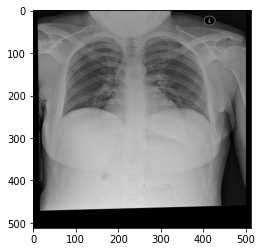

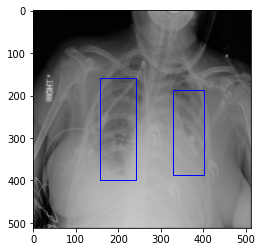

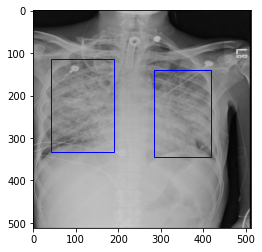

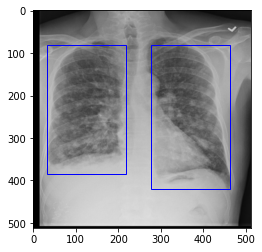

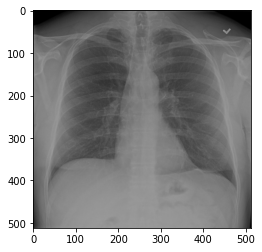

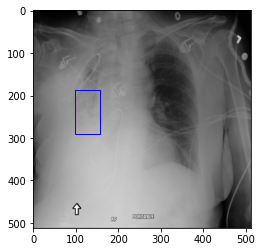

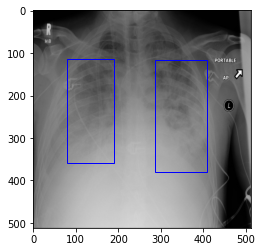

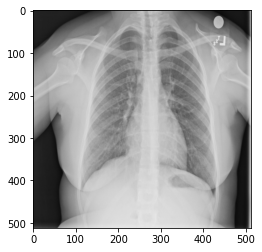

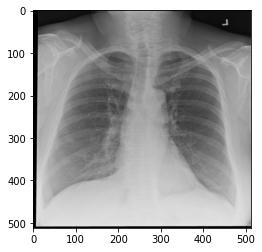

In [23]:
# plot first few images
for i in range(9):
    # define subplot
    fig, ax = plt.subplots(1)
#     plt.figure(figsize=(12, 12))
#     plt.subplot(330 + 1 + i)
    # plot raw pixel data
    image = train_set.load_image(i)
#     plt.imshow(image)
    # plot all masks
    mask, _ = train_set.load_mask(i)
    bboxes = extract_bboxes(mask)
    for bbox in bboxes:
        if np.sum(bbox) == 0:
            break
        y, x, y_, x_ = bbox 
        h, w = y_ - y, x_ - x
        patch = Rectangle((x, y), w, h, color='blue', fill=False)
        ax.add_patch(patch)
    ax.imshow(image)

# show the figure
plt.show()

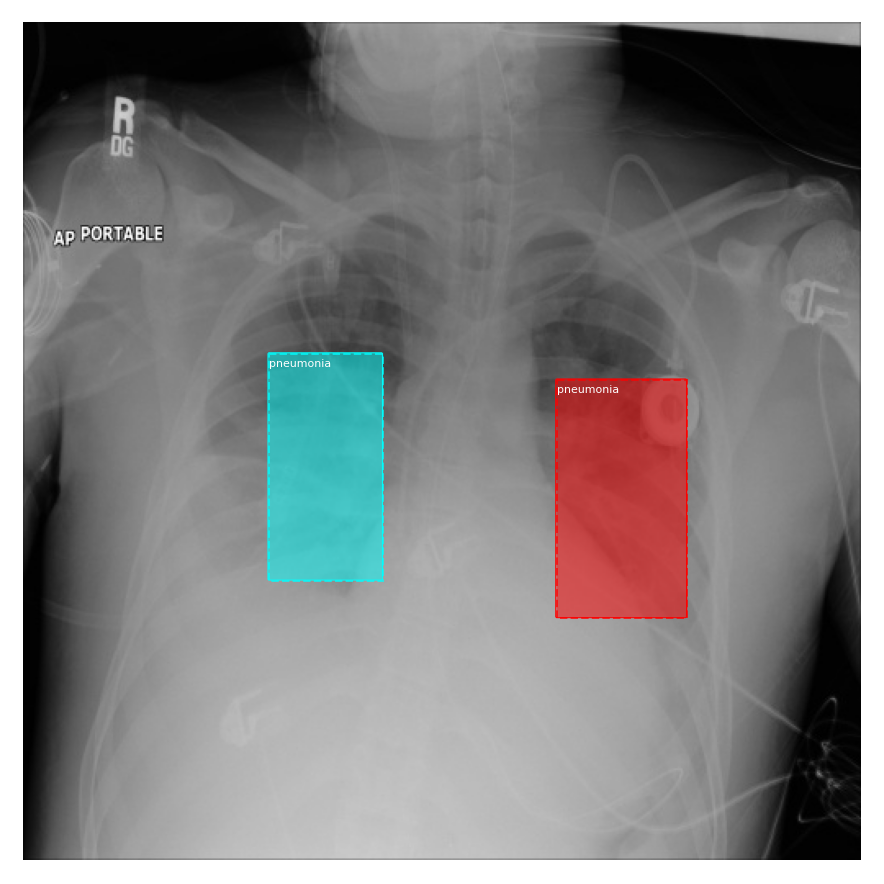

In [24]:
image_id = 42
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

### calculating mean-value of images

In [25]:
# means = np.empty(shape=len(train_set.image_ids), dtype='uint8')
# for i, image_id in enumerate(train_set.image_ids):
#   # load the image
#   image = train_set.load_image(image_id)
#   mean = image.mean()
#   means[i] = mean

# MEAN = means.mean()
# print(MEAN)

#### mean-value turns out to be 124.57

In [26]:
# define a configuration of the model
class PneumoniaConfig(Config):
    # Give the configuration a recognizable name
    NAME = 'pneumonia_cfg'
    # Number of class (background + pneumonia)
    NUM_CLASSES = 1 + 1        

    # Adjust based on your GPU memory and image sizes. Use the highest
    # number that your GPU can handle for best performance.
    IMAGES_PER_GPU = 8

    # Number of training steps per epochs
    STEPS_PER_EPOCH = 1000 // IMAGES_PER_GPU

    # Number of validation steps to run at the end of every training epoch.
    # A bigger number improves accuracy of validation stats, but slows
    # down the training.
    VALIDATION_STEPS = 80 // IMAGES_PER_GPU

    # Length of square anchor side in pixels
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # Image mean (RGB)
    MEAN_PIXEL = np.array([124.57, 124.57, 124.57])  

    IMAGE_RESIZE_MODE = 'square'
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    
    IMAGE_CHANNEL_COUNT = 3


    BACKBONE = 'resnet50'

    TRAIN_ROIS_PER_IMAGE = 128

    MAX_GT_INSTANCES = 50
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.8

    # DETECTION_NMS_THRESHOLD = 0.01

    LEARNING_RATE = 0.001

    

# prepare config
config = PneumoniaConfig()
print(config.LEARNING_RATE)

0.001


In [27]:
# Directory to save logs and trained model
if 'logs' not in os.listdir():
  os.mkdir('logs')
MODEL_DIR = str(Path.cwd() / 'logs')

In [28]:
config.IMAGES_PER_GPU

8

In [29]:
# define the model
model = MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [30]:
# COCO_MODEL_PATH = 'mask_rcnn_coco.h5'

In [31]:
# if 'mask_rcnn_coco.h5' not in os.listdir():
#   import wget
#   wget.download('https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5')

In [32]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [33]:
# model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                                          #  "mrcnn_bbox", "mrcnn_mask"])

# load save model
# model_path = model.find_last()
# model_path = '/content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200928T1621/mask_rcnn_pneumonia_cfg_0035.h5'
# model.load_weights(model_path, by_name=True)

### Training

In [34]:
# Train resnet stage 4 and up (layers='4+')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=30, layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200929T1124/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_

In [35]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=50, layers='all')


Starting at epoch 30. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200929T1124/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=60, layers='all')


Starting at epoch 50. LR=0.001

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200929T1124/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE/2, epochs=14, layers='all')


Starting at epoch 10. LR=0.0005

Checkpoint Path: /content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200927T1313/mask_rcnn_pneumonia_cfg_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multi

Epoch 11/14
125/125 [==============================] - 235s 2s/step - loss: 1.0718 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.3358 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.3343 - mrcnn_mask_loss: 0.3415 - val_loss: 1.1218 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.3055 - val_mrcnn_class_loss: 0.0655 - val_mrcnn_bbox_loss: 0.3727 - val_mrcnn_mask_loss: 0.3736
Epoch 12/14
125/125 [==============================] - 133s 1s/step - loss: 1.0008 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.2928 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3173 - mrcnn_mask_loss: 0.3422 - val_loss: 1.2468 - val_rpn_class_loss: 0.0062 - val_rpn_bbox_loss: 0.2647 - val_mrcnn_class_loss: 0.1246 - val_mrcnn_bbox_loss: 0.4432 - val_mrcnn_mask_loss: 0.4081
Epoch 13/14
125/125 [==============================] - 133s 1s/step - loss: 0.9971 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.2841 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.3366 - val_loss: 1.3851 - val_rpn_clas

## Inference

In [ ]:
# define the prediction configuration
class InferenceConfig(Config):
	# define the name of the configuration
	NAME = "pneumoniua_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1

	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	
	# Length of square anchor side in pixels
	RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

	# Image mean (RGB)
	MEAN_PIXEL = np.array([124.57, 124.57, 124.57])  

	IMAGE_RESIZE_MODE = 'square'
	IMAGE_MIN_DIM = 512
	IMAGE_MAX_DIM = 512

	BACKBONE = 'resnet50'

	TRAIN_ROIS_PER_IMAGE = 128

	# Minimum probability value to accept a detected instance
	# ROIs below this threshold are skipped
	DETECTION_MIN_CONFIDENCE = 0.8

	DETECTION_NMS_THRESHOLD = 0.01

	MAX_GT_INSTANCES = 50

In [ ]:
# create config
cfg = InferenceConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

In [ ]:
# model_path = model.find_last()
model_path = '/content/drive/My Drive/pneumonia_detection/logs/pneumonia_cfg20200927T1313/mask_rcnn_pneumonia_cfg_0052.h5'
model.load_weights(model_path, by_name=True)

Re-starting from epoch 52


In [ ]:
# compute_overlaps()

In [ ]:
image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(train_set, cfg, 4200, use_mini_mask=False)
scaled_image = mold_image(image, cfg)
sample = np.expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)
r = yhat[0]
# overlap(gt_bbox, r['rois'])
# Ap, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)
# print(Ap)

In [ ]:
r['class_ids']

array([1, 1], dtype=int32)

In [ ]:
class_id = 
images_cropped = []
class_fltr = r['class_ids'] == class_id
boxes = r['rois'][class_fltr, :]
for box in boxes:
  y1, x1, y2, x2 = box
  cropped = image[y1: y2, x1: x2]
  images_cropped.append(cropped)

In [ ]:
r['class_ids']

array([1, 1], dtype=int32)

In [ ]:
images_cropped[0].shape

(109, 89, 3)

In [ ]:
def evaluate_model(dataset, model, cfg):
  APs = []
  image_ids = dataset.image_ids[:100]
  for image_id in image_ids:
    # load image, bounding boxes and masks for the image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    # convert pixel values (subtract MEAN_PIXEL)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = np.expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    # calculate statistics include AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.5)
    # store
    if np.isnan(AP):
      APs.append(0)
      continue
    APs.append(AP)
  mAP = np.mean(APs)
  return mAP, APs

In [ ]:
# evaluate model on training set
# train_mAP = evaluate_model(train_set, model, cfg)
# print('Train mAP: %.3f' % train_mAP)
# evaluate model on test set
test_mAP, test_APs = evaluate_model(test_set, model, cfg)
print('Test mAP: %.3f' % test_mAP)

Test mAP: 0.107


#### Visualize predictions

In [ ]:
from mrcnn.visualize import display_instances


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



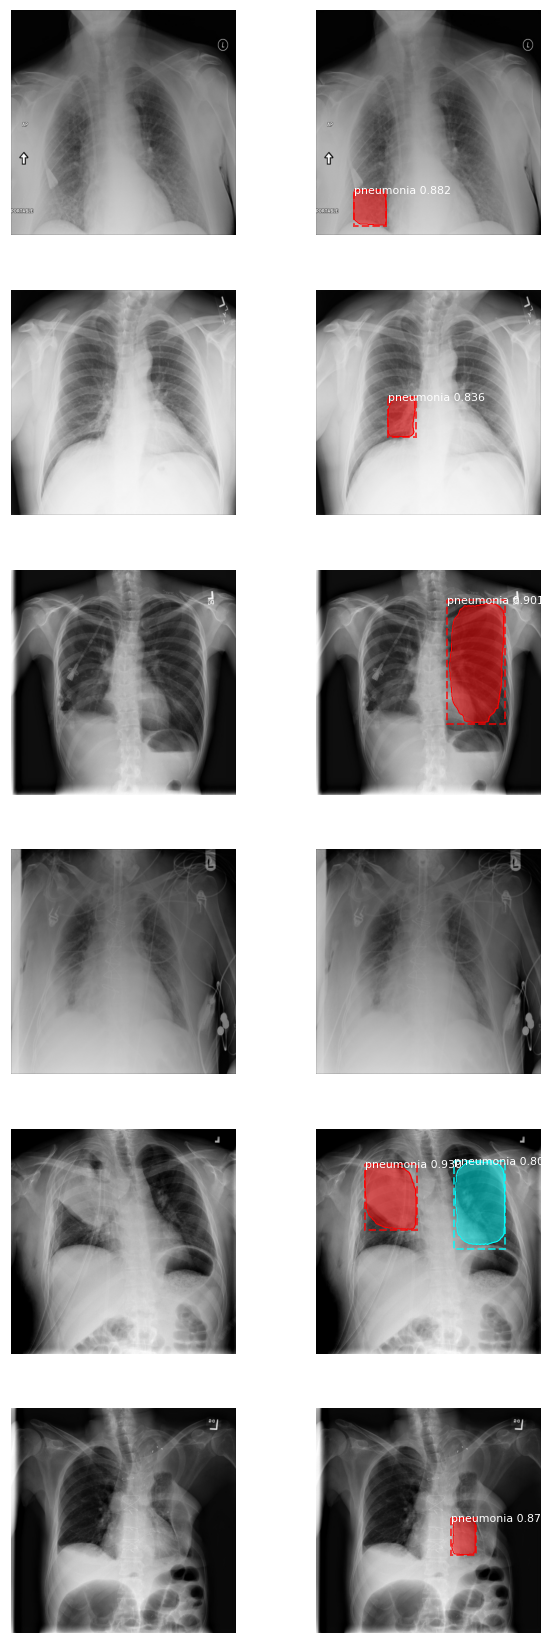

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = train_set
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = np.random.choice(dataset.image_ids)
    # image_id = 100 * i
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    plt.subplot(6, 2, 2*i + 1)
    display_instances(image, gt_bbox, gt_mask, gt_class_id, dataset.class_names, ax=fig.axes[-1])
    scaled_image = mold_image(image, cfg)
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([scaled_image]) #, verbose=1)
    r = results[0]
    display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'], ax=fig.axes[-1])